# Final Task - Multiclass classification of spacial data
### Authors: Mateusz Kulpiński & Patrycja Czemerych

## Fashion MNIST dataset

The Fashion MNIST is a dataset developed by Zalando Research. It comprises 70,000 grayscale images categorized into 10 fashion-related items. The dataset is divided into a training set of 60,000 images and a test set of 10,000 images.

The 10 labels of the dataset include:
1. T-shirt/top
2. Trouser
3. Pullover
4. Dress
5. Coat
6. Sandal
7. Shirt
8. Sneaker
9. Bag
10. Ankle boot


### Dataset technical description:
- Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total.
- Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. 
- The training and test data sets have 785 columns. 
- The first column consists of the class labels (see above), and represents the article of clothing. 
- The rest of the columns contain the pixel-values of the associated image.

## CNN

For the purpose of this task we will use CNN. Convolutional Neural Networks (CNNs) are a class of deep neural networks that are particularly effective for processing structured grid data, such as images. Unlike traditional fully connected networks, CNNs are designed to automatically and adaptively learn spatial hierarchies of features from images.

![](https://media.licdn.com/dms/image/v2/D5612AQGOui8XZUZJSA/article-cover_image-shrink_720_1280/article-cover_image-shrink_720_1280/0/1680532048475?e=2147483647&v=beta&t=5gZVHYNL2Vc2mK3iKrpK-FcpURIFdyaP4Vi38eeeZyM)
###### Source: https://www.linkedin.com/pulse/what-convolutional-neural-network-cnn-deep-learning-nafiz-shahriar

Core components of CNNs are:
1. Input Layer - The process begins with the input image, which is typically represented as a 2D matrix (for grayscale images) or a 3D matrix (for colored images). The dimensions of the image are typically height × width × channels.

2. Convolutional Layer - It applies a set of filters (also known as kernels) to the input image. Each filter is a matrix that slides across the entire image. The filter is multiplied element-wise within a region of the image, and the results is a single value. This operation is repeated for every part of the image, creating a feature map that represents the learned patterns (such as edges, textures, or specific shapes). In this procedure it is important to consider 2 parameters:
    - Stride - defines how far the filter moves after each operation, 
    - Paddding - used when the filter would slide over the edges of the image and produce smaller outputs. Padding ensures that the spatial dimensions of the output feature map are not reduced too much (i.e. padding with zeros).

3. Activation Functions - Activation function transforms all negative values to zero, leaving only the positive values. This helps the model capture non-linear patterns and ensures that the network can learn more complex relationships.

4. Pooling Layer - Pooling methods (like Average or Max pooling) reduce spatial dimensions of the feature maps produced by the convolutional layer. Pooling helps reduce the computational load, prevents overfitting, and retains important features.

5. Fully Connected Layer - The vector of features is passed through a fully connected layer consists of neurons that are connected to every neuron in the previous layer. The purpose of these layers is to combine the learned features from the previous layers to make a prediction.

6. Output Layer - The model will predict the class with the highest probability.


How it works:
1. Image is fed into the network.

2. Filters convolve with the image to extract local features (edges, textures), and ReLU introduces non-linearity.

3. Pooling layers downsample the feature maps, retaining the important features while reducing dimensionality.

4. High-level features are combined to make a decision using Fully Connected Layers.

5. The final classification decision is made using a softmax layer at the output.

6. Backpropagation and gradient descent are used to update the network’s weights to minimize the loss.

## Step 1: Necessary imports

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow_datasets.core.utils.lazy_imports_utils import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import random
from tensorflow.keras.callbacks import EarlyStopping

## Step 2: Loading the dataset and spliting

We define a function to download and prepare the data. To handle this, we use the TensorFlow Datasets (TFDS) library.

It is necessary to split the datasets into training, testing and validation sub-sets. Additionally, the original dataset doesn't provide validation, so we split the training set into training and validation sets manually. The 80% of the original training set will remain for training purposes, while the 20% will be utilized for validation.

Lastly, we can check information about the FashionMnist dataset, such as credits to original authors and structure of the data.

In [18]:
def download_and_prepare_data(dataset_name='fashion_mnist', val_size=0.2): # as_supervised=True ensures that the data is returned as (image, label) pairs, which is important for supervised learning
    # Load the dataset
    dataset, info = tfds.load(name=dataset_name, with_info=True, as_supervised=True)
    
    # Splitting into training, validation, and testing stes
    train_data, test_data = dataset['train'], dataset['test']
    
    val_size = 0.2
    train_size = int((1 - val_size) * len(list(train_data)))
    train_data, val_data = train_data.take(train_size), train_data.skip(train_size)
    
    return train_data, val_data, test_data, info

# Download and prepare the data
train_data, val_data, test_data, info = download_and_prepare_data()

# Check the structure of the dataset
print("Dataset Information:", info)
print("Example data format:", next(iter(train_data)))


Dataset Information: tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir='/Users/patrycjaczemerych/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:jour

Lets observe how many samples we have in each subset.

In [19]:
# Get dataset sizes using the `.cardinality()` method
train_sample_count = train_data.cardinality().numpy()
val_sample_count = val_data.cardinality().numpy()
test_sample_count = test_data.cardinality().numpy()

# Print the sample counts
print(f"Number of training samples: {train_sample_count}")
print(f"Number of validation samples: {val_sample_count}")
print(f"Number of testing samples: {test_sample_count}")


Number of training samples: 48000
Number of validation samples: 12000
Number of testing samples: 10000


## Step 3: Visualising data

Now, lets examine examples from FashionMNIST, example images of clothing items and class labels.

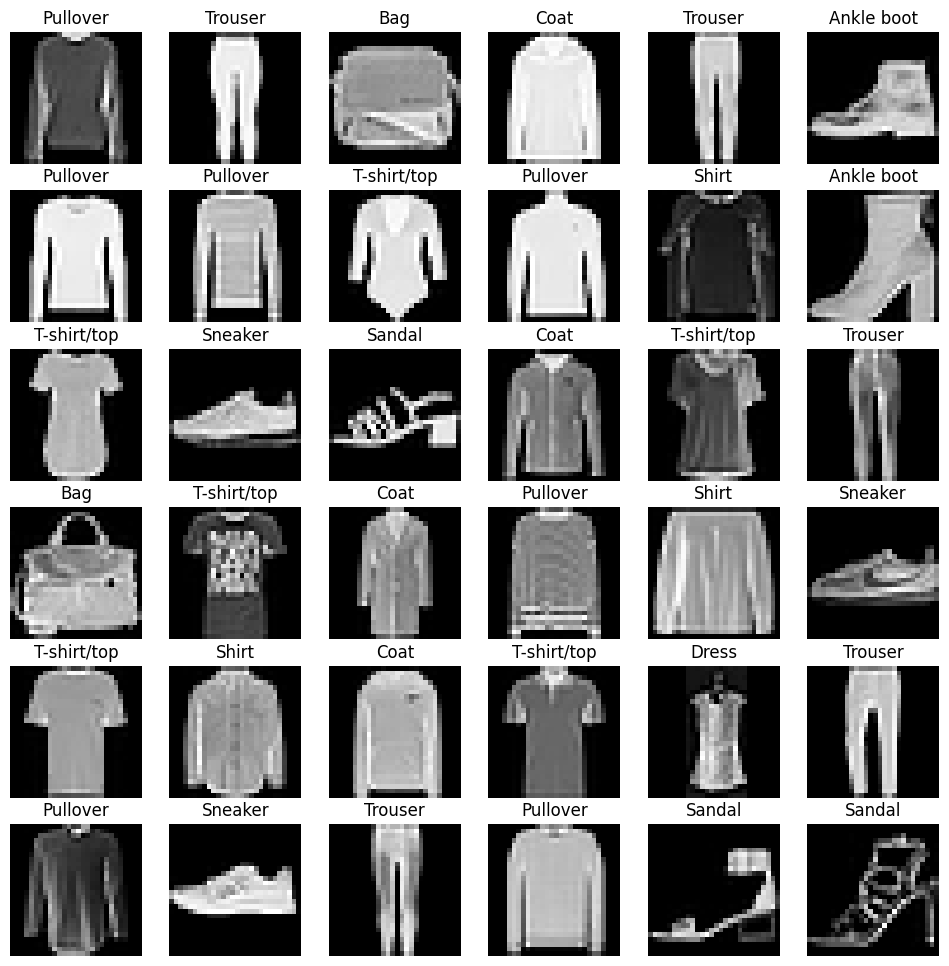

In [20]:
class_names = info.features['label'].names  # Class names

# Function to visualize a batch of images and their labels
def plot_sample_images(dataset, num_images):
    plt.figure(figsize=(12, num_images // 6 * 2))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(6, 6, i+1)
        plt.imshow(image.numpy().astype("uint8"), cmap='gray')
        label_index = int(label.numpy())
        plt.title(class_names[label_index])
        plt.axis('off')
    plt.show()

# Visualize sample images from the train data
plot_sample_images(train_data, num_images=36)


## Step 4: Visualising the distribution

Lets also observe the distribution of samples in the training, validation, and test datasets for each class. In order to do that we will extract the labels from each dataset and plot its distribution.

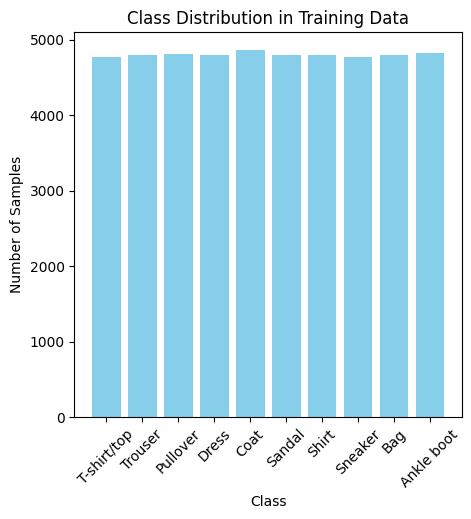

2025-01-15 18:18:48.215458: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


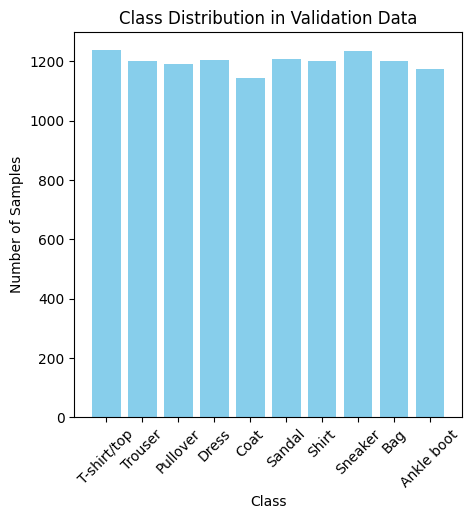

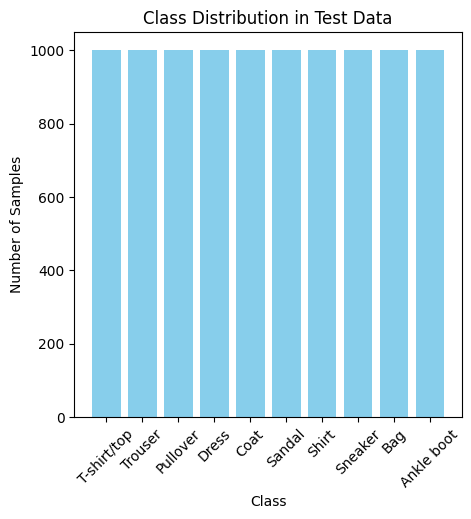

In [6]:
def plot_class_distribution(dataset, dataset_name="Dataset"):
    # Extract labels from the dataset
    labels = [label.numpy() for _, label in dataset]
    
    # Count the occurrences of each label
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    plt.figure(figsize=(5,5))
    plt.bar(class_names, counts, color='skyblue')
    plt.title(f'Class Distribution in {dataset_name}')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(unique_labels)
    plt.xticks(rotation=45)
    plt.show()

# Plot the class distribution for train, validation, and test data
plot_class_distribution(train_data, "Training Data")
plot_class_distribution(val_data, "Validation Data")
plot_class_distribution(test_data, "Test Data")


As we can observe, when splitting training dataset the classes are not splited equally. However, as we are dealing with a large number of data (50000 samples), those differences should not influance the the results in a major way.

## Step 5: Data preprocessing

The data preprocessing involves normalizing the images (pixel intensity) to a range [0, 1] and splitting them into batches (which will speed up the learning process). Lastly, we ensure the data shapes are compatible with the model input requirements.

- Normalization - Improves model convergence by standardizing input values, reducing the variance, and helping the optimizer learn more efficiently.
- Batching - Divides data into manageable chunks for memory efficiency and smoother gradient updates.

In [22]:
# Normalize images
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalizing pixel intensity
    return image, label

# Divide into batches
train_data = train_data.map(preprocess).batch(32).shuffle(1000)
val_data = val_data.map(preprocess).batch(32)
test_data = test_data.map(preprocess).batch(32)

# Get input shape
input_shape = info.features['image'].shape 
num_classes = info.features['label'].num_classes

print("Input data shape:", input_shape)
print("Number of classes in the dataset:", num_classes)

Input data shape: (28, 28, 1)
Number of classes in the dataset: 10


## Step 6: building the CNN model

In this step, we construct a Convolutional Neural Network (CNN) to perform multiclass classification. CNNs are particularly effective for image data due to their ability to capture spatial hierarchies and features in the data.

Model Architecture:
- Input Layer - Accepts input data of shape (28, 28, 1), representing grayscale images.

- 3 Convolutional Layer - Applies first 64, then 32 and lastly 32 filters of size 3x3 to extract local patterns (edges, textures, etc.).

- Activation function - ReLU, which introduces non-linearity.

- 3 MaxPooling Layers - Reducesspatial dimensions by 2, decreasing computational load and retaining essential features.

- Dropout - Randomly sets 20% of the neurons to 0 during training to prevent overfitting.

- Flatten Layer - Converts the 2D output from previous layers into a 1D vector for input into dense layers.

- Output (Dense) Layer -Contains 10 neurons (equal to the number of classes) with a softmax activation function to produce a probability distribution over the classes.


Model Compilation 
- Optimizer - Adam, a widely used optimizer that combines the benefits of momentum and RMSProp.

- Loss Function - Sparse Categorical Crossentropy, ideal for integer-labeled multiclass classification problems.

- Metric - Accuracy, to track the percentage of correctly classified samples during training and evaluation.

In [58]:
cnn_model = Sequential([
    Conv2D(filters=64,kernel_size=3,activation='relu',input_shape = input_shape, padding='same'),
    MaxPooling2D(pool_size=2), # down-sampling the output instead of 28*28 it is now 14*14
    Conv2D(filters=32,kernel_size=3,activation='relu',input_shape = input_shape, padding='same'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=32,kernel_size=3,activation='relu',input_shape = input_shape, padding='same'),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(10,activation = 'softmax') 
    
])


# Compile the model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

/Users/patrycjaczemerych/Documents/sem_2/sem_2_venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Step 7: Training the model

With the use of early stopping we can prevent overfitting by ending training when validation performance stops improving.

In [59]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Stop after 5 epochs of no improvement
    restore_best_weights=True  # Revert to the best model weights
)

history = cnn_model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7035 - loss: 0.8272 - val_accuracy: 0.8678 - val_loss: 0.3627
Epoch 2/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.8590 - loss: 0.3931 - val_accuracy: 0.8737 - val_loss: 0.3383
Epoch 3/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.8775 - loss: 0.3366 - val_accuracy: 0.8898 - val_loss: 0.2903
Epoch 4/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.8859 - loss: 0.3161 - val_accuracy: 0.9009 - val_loss: 0.2675
Epoch 5/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.8951 - loss: 0.2889 - val_accuracy: 0.9044 - val_loss: 0.2592
Epoch 6/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.8995 - loss: 0.2745 - val_accuracy: 0.9094 - val_loss: 0.2402
Epoch 7/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9074 - loss: 0.2561 - val_accuracy: 0.9089 - val_loss: 0.2433
Epoch 8/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.9119 - loss: 0.24

The model was trained with 30 epochs however it stopped at 24. We observed steady improvement in accuracy and reduction in loss during the initial epochs. However, as the training progressed, the model began to converge, and improvements became less significant.

## Step 8: Ploting results

Lets observe how the learning process of the model progresses over each epoch. We are plotting values of accuracy and loss for training and validation data.

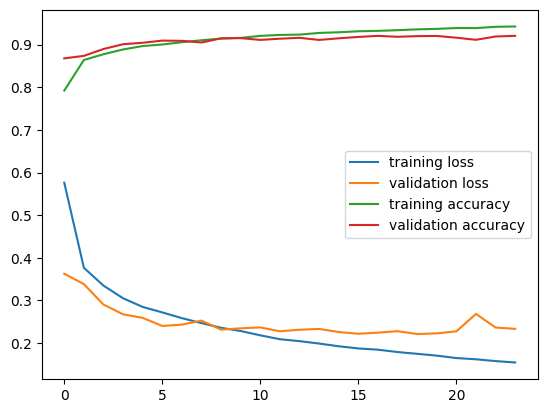

In [60]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training loss','validation loss','training accuracy','validation accuracy'])
plt.show()

Text(0.5, 1.0, 'Training - Accuracy')

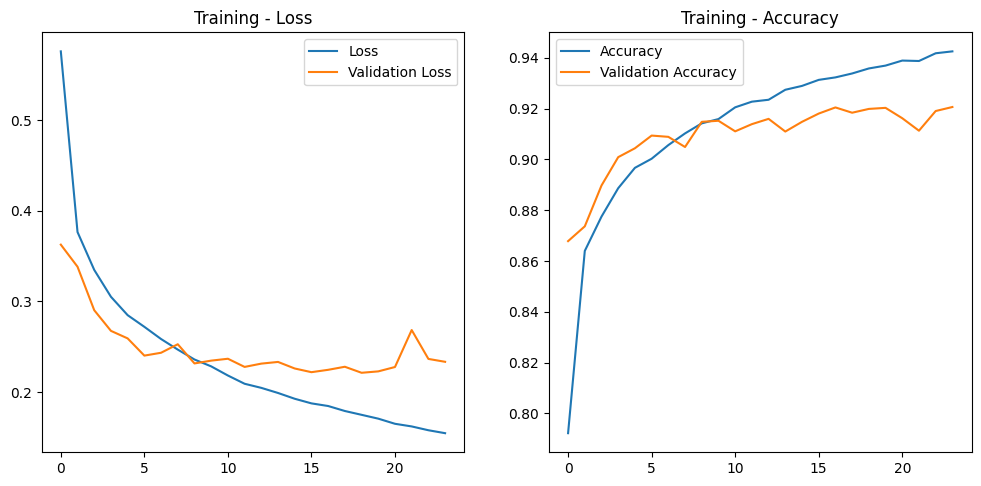

In [61]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training - Accuracy')

Training vs. Validation Loss:
- Training loss decreases consistently, but validation loss begins to stabilize and shows minimal improvement beyond a certain point.
- The gap between training and validation loss indicates slight overfitting, which is typical in deep learning models.

Training vs. Validation Accuracy:
- Training accuracy continuously improves, reaching ~94%.
- Validation accuracy remains slightly lower (~92%), indicating good generalization.

## Step 9: Evaluating the model

Now we can evaluate how the trained model will perform on test data - the data it hasn't seen before.

In [62]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9155 - loss: 0.2365
Test Loss: 0.2483, Test Accuracy: 0.9122


As expected the loss value is higher and accuracy is lower than in the case of training results.

Finally, we can observe our CNN model in practise. We will get 5 random images and examine if the model will predict correct labels for them.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


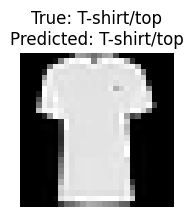

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


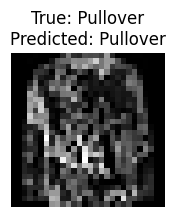

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


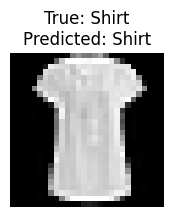

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


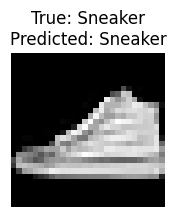

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


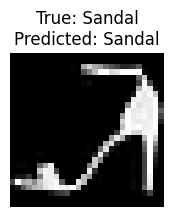

In [63]:
def evaluate_random_samples(test_dataset, cnn_model, class_names, num_samples=5):
    # Unbatch the dataset to iterate through individual samples
    unbatched_test_data = test_dataset.unbatch()
    
    # Collect all samples into a list
    test_samples = list(unbatched_test_data)
    
    # Randomly select a few samples
    random_samples = random.sample(test_samples, num_samples)
    
    for i, (image, label) in enumerate(random_samples):
        # Expand dimensions of the image to match model input shape (batch size = 1)
        image_batch = tf.expand_dims(image, axis=0)
        
        # Get the model's prediction
        predictions = cnn_model.predict(image_batch)
        predicted_label = tf.argmax(predictions[0]).numpy()
        
        # Display the image, true label, and predicted label
        plt.figure(figsize=(2, 2))
        plt.imshow(image.numpy().squeeze(), cmap='gray')
        plt.title(f"True: {class_names[label]}\nPredicted: {class_names[predicted_label]}")
        plt.axis('off')
        plt.show()

# Evaluate random samples
evaluate_random_samples(test_data, cnn_model, class_names, num_samples=5)

# 🥳🥳🥳

## Conclusions & Observations

- Increasing the number of epochs positively impacts accuracy of the model while training, however it doesn't lead to better accuracy on training set.

- Validation accuracy peaked around ~92%, suggesting that 24 epochs were sufficient for optimal training without excessive overfitting, thanks to early stoping.

- The best results are reached for a CNN model with 3 Convolutional layers, first one wit 64 neurons, secon with 32 neurons and last with 32 neurons.

- When it comes to compyling the model, it was best to use Adam as an optimizer wit a learning step of 0.001 and SparseCategoricalCrossentropy to calculate the loss function.

- Finally the accuracy values are: ~94% (training), ~92% (validation) and ~92% (testing).

- Whereas, the loss values are: 0.156 (training), 0.233 (validation), 0.237 (testing).